<a href="https://colab.research.google.com/github/zahraDehghanian97/Self_Organizing_Map/blob/master/SOFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **prerequisit**

In [63]:
try :
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
from csv import reader
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from PIL import Image
import glob
import pickle
import random


## mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **make dataset ready**

In [50]:
def load_photos(dir_name):
    photo_list =[]
    name_list = []
    labels = []
    for file_name in (glob.glob(dir_name+'/*')):
        image = Image.open(file_name)
        image = np.array(image).flatten()
        photo_list.append(image)
        x = file_name.split('/')
        name_list.append(x[6])
        labels.append(x[6].split('.')[1])
    photo_list = np.array(photo_list)
    photo_list = np.array(preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(photo_list))
    unique_value =list(set(labels))
    y = []
    for label in labels :
      y.append(unique_value.index(label))
    return photo_list , name_list , y , labels
  
    

dir_name = "/content/drive/MyDrive/Colab Notebooks/yalefaces"
X , name_list , y ,labels= load_photos(dir_name) 
labels_list = list(set(labels))
n_features =len(X[0])
n_classes = len(list(set(y)))
print(n_classes)
print(X[0])
print(n_features)
print(y)



11
[1. 1. 1. ... 0. 0. 0.]
77760
[10, 7, 8, 9, 2, 3, 4, 6, 5, 1, 0, 7, 10, 8, 9, 2, 3, 6, 4, 1, 5, 0, 7, 8, 10, 9, 3, 2, 6, 4, 1, 5, 0, 7, 8, 10, 9, 2, 6, 3, 1, 5, 0, 7, 10, 8, 9, 2, 6, 3, 1, 4, 5, 7, 0, 10, 8, 9, 2, 6, 3, 4, 5, 1, 0, 7, 10, 8, 9, 2, 6, 3, 4, 1, 5, 0, 7, 10, 9, 8, 2, 6, 3, 4, 5, 1, 0, 10, 7, 8, 2, 9, 6, 3, 4, 1, 0, 5, 10, 7, 8, 2, 9, 3, 4, 6, 1, 0, 5, 7, 10, 8, 9, 2, 3, 4, 6, 1, 5, 0, 7, 10, 8, 9, 3, 2, 4, 6, 1, 0, 5, 7, 10, 8, 9, 3, 2, 6, 4, 1, 5, 0, 7, 8, 10, 9, 2, 3, 4, 6, 1, 0, 5, 7, 10, 8, 2, 9, 3, 4, 6, 1, 0, 5, 4]


# **SOM Class**

Iteration: 0, LR: 0.100000, R: 3.000000, J: 8.167553
Iteration: 1, LR: 0.099600, R: 2.988000, J: 7.896381
Iteration: 2, LR: 0.099200, R: 2.976000, J: 5.104801
Iteration: 3, LR: 0.098800, R: 2.964000, J: 5.030695
Iteration: 4, LR: 0.098400, R: 2.952000, J: 4.951870
Iteration: 5, LR: 0.098000, R: 2.940000, J: 4.809063
Iteration: 6, LR: 0.097600, R: 2.928000, J: 4.657841
Iteration: 7, LR: 0.097200, R: 2.916000, J: 4.699627
Iteration: 8, LR: 0.096800, R: 2.904000, J: 4.605296
Iteration: 9, LR: 0.096400, R: 2.892000, J: 4.395615
Iteration: 10, LR: 0.096000, R: 2.880000, J: 4.356339
Iteration: 11, LR: 0.095600, R: 2.868000, J: 4.347993
Iteration: 12, LR: 0.095200, R: 2.856000, J: 4.341595
Iteration: 13, LR: 0.094800, R: 2.844000, J: 4.053253
Iteration: 14, LR: 0.094400, R: 2.832000, J: 4.011510
Iteration: 15, LR: 0.094000, R: 2.820000, J: 3.960093
Iteration: 16, LR: 0.093600, R: 2.808000, J: 3.870529
Iteration: 17, LR: 0.093200, R: 2.796000, J: 4.090906
Iteration: 18, LR: 0.092800, R: 2.7840

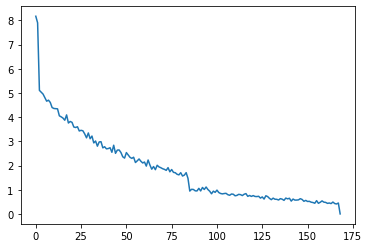

[[0. 7. 3. 0. 6. 0.]
 [0. 0. 0. 0. 4. 0.]
 [6. 6. 8. 1. 0. 9.]
 [4. 1. 2. 7. 7. 9.]
 [0. 0. 0. 2. 0. 1.]
 [6. 0. 0. 9. 0. 0.]]


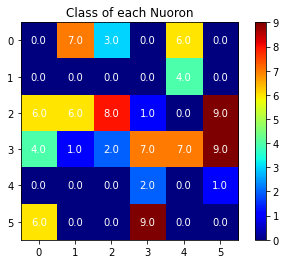

Meaning of each number :
[ 0  1  2  3  4  5  6  7  8  9 10]
['wink', 'sleepy', 'noglasses', 'normal', 'sad', 'surprised', 'rightlight', 'centerlight', 'happy', 'leftlight', 'glasses']


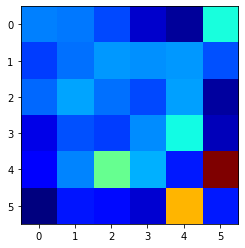

In [55]:
class SOM:
    def __init__(self,data, map_size, lr = 0.1):
        self.map = np.zeros(shape=map_size)
        ind = np.random.choice(data.shape[0],(map_size[0], map_size[1]) , replace=False)
        for i in range(map_size[0]):
          for j in range (map_size[1]):
            self.map[i,j] = data[ind[i,j]]
        self.lr0 = lr
        self.lr = self.lr0
        self.R0 = map_size[0]//2
        self.R = self.R0
        
    def train(self, X, y, T=1000, error_threshold=10**-20): 
        Js = []
        for t in range(T):
            prev_map = np.copy(self.map)
            shuffle_ind = np.random.randint(low=0, high=len(X), size=len(X))  # a vector of random indices
            for i in range(len(X)):
                x = X[shuffle_ind[i],:]
                x = np.asarray(x)
                winner = self.find_winner(x)    # winner = [1,4]
                NS = self.get_NS(winner)
                self.update_weights(x, NS, len(X))
            self.lr = self.lr0 * (1 - t/T)
            self.R = self.R0 * (1 - t/T)
            Js.append(np.linalg.norm(prev_map - self.map))     # norm of changes
            # if t % 10 == 0:
            #     print('Iteration: %d, LR: %f, R: %f, J: %f' %(t, self.lr, self.R, Js[-1]))
            print('Iteration: %d, LR: %f, R: %f, J: %f' %(t, self.lr, self.R, Js[-1]))
                # self.visualize(X, y)
            if Js[-1] < error_threshold:
                print('Min changes')
                break
        return Js
            
    def find_winner(self, x):
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        dists = np.sum((self.map - rep_x)**2, axis=2)   
        winner = np.unravel_index(np.argmin(dists, axis=None), dists.shape)
        return winner
    
    def get_NS(self, winner):
        # not neighbor = 0 , neighbor = 1/sqrt(euclidean_distance)
        NS = np.zeros(shape= (self.map.shape[0], self.map.shape[1]))
        iw, jw = winner[0], winner[1]
        R = int(self.R)
        for ri in range(-R, R):
            for rj in range(-R, R):
                if (0 <= iw + ri < self.map.shape[0]) and  (0 <= jw + rj < self.map.shape[1]):   
                    NS[iw + ri, jw + rj] = 0 if np.sqrt(ri**2 + rj**2) > R else 1/ ( 1+ np.sqrt(ri**2 + rj**2))  
        return NS
    
    def update_weights(self, x, n_strength, X_len):
        NS = np.tile(n_strength, [self.map.shape[2],1,1]).transpose()
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        Delta = rep_x - self.map 
        self.map = self.map + (self.lr/X_len) * np.multiply(NS, Delta)

    def visualize(self, X, y):
        scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1],len(list(set(y)))))  
        self.scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1]))  
        for i in range(len(X)):
            x = X[i, :]
            x = np.asarray(x)
            winner = self.find_winner(x)
            iw, jw = winner[0], winner[1]
            scores[iw, jw][y[i]] += 1
        for i in range(len(scores)):
            for j in range(len(scores[0])):
              self.scores[i,j] = np.argmax(scores[i,j])
        print(self.scores)

        c = plt.imshow(self.scores, cmap='jet')
        plt.colorbar(c)
        for i in range(len(scores)):
          for j in range(len(scores[0])):
            plt.text(j,i, self.scores[i, j],ha="center", va="center", color="w")
        plt.title("Class of each Nuoron")
        plt.show()
        

    def extract_feature(self, x): # here we give a data of n feature and take a matrix of size map as output (e.g, 9*9)
        x = np.asarray(x)
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[0], 1])
        dists = np.sum((self.map - rep_x)**2, axis=2)
        return 1/ (1 + dists)
     
   
m_size = 6
som_net = SOM(data = X,map_size = [m_size,m_size,n_features])
Js = som_net.train(X, y, T = 250)
plt.plot(Js)
plt.show()

som_net.visualize(X, y)
print("Meaning of each number :")
print(np.arange(len(labels_list)))
print(labels_list)

x = X[0,:]
features = som_net.extract_feature(x)
plt.imshow(features)
plt.show()
    

save founded map 

In [68]:
data_path = '/content/drive/MyDrive/Colab Notebooks/map6*6.txt'
# with open(data_path, 'wb') as f:
#     pickle.dump(som_net.map, f)

with open(data_path, "rb") as f:
    x = pickle.load(f)
print(x)


[[[0.88252859 0.9597923  0.97998474 ... 0.         0.         0.        ]
  [0.95613066 0.97227993 0.97696049 ... 0.         0.         0.        ]
  [0.86757808 0.87314169 0.9385124  ... 0.         0.         0.        ]
  [0.88364988 0.81419089 0.78903368 ... 0.         0.         0.        ]
  [0.85093346 0.81547933 0.82999224 ... 0.         0.         0.        ]
  [0.90591215 0.89281312 0.89264043 ... 0.         0.         0.        ]]

 [[0.93486916 0.94370675 0.96615283 ... 0.         0.         0.        ]
  [0.95153513 0.96731596 0.98276377 ... 0.         0.         0.        ]
  [0.92965296 0.9341278  0.97275207 ... 0.         0.         0.        ]
  [0.99170385 0.99066434 0.98947008 ... 0.         0.         0.        ]
  [0.97465921 0.97375532 0.97486084 ... 0.         0.         0.        ]
  [0.96876621 0.96720675 0.97108472 ... 0.         0.         0.        ]]

 [[0.87618509 0.86283234 0.90144137 ... 0.         0.         0.        ]
  [0.96194508 0.95361933 0.9628254